In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn import decomposition
from sklearn.decomposition import FactorAnalysis as FA
from sklearn import preprocessing
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, homogeneity_score, silhouette_score, classification_report
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve
import warnings
warnings.filterwarnings("ignore")

In [2]:
dataset_select =     1    # 0 for wine , 1 for cancer

In [3]:
if dataset_select == 0:
    wine = pd.read_csv('data/wine.csv',sep=';')
    print('Wine Quality Dataset')
    print(wine.shape)
    bins = (2, 6.5, 8)
    group_names = ['bad','good']
    wine['quality'] = pd.cut(wine['quality'], bins=bins,labels=group_names)
    wine = wine.dropna()
    wine_label_quality = LabelEncoder()
    wine['quality'] = wine_label_quality.fit_transform(wine['quality'])
    df = wine
    X = wine.drop('quality',axis=1)
    y = wine['quality']
    dataset='wine'
elif dataset_select == 1:
    print('Cancer Dataset')
    cancer = pd.read_csv('data/cancer.csv')
    print(cancer.shape)
    cancer = cancer.dropna()
    cancer['class']=cancer['class'].map({4:1, 2:0})
    df = cancer
    X = cancer.drop(['id','class'],axis=1)
    y = cancer['class'] 
    dataset='cancer'
else:
    raise Exception('dataset_select field must be 0 for wine , 1 for cancer')

X = MinMaxScaler().fit_transform(X)

Cancer Dataset
(699, 11)


In [4]:
fa_7 = FA(n_components=5, random_state=44)
fa_7.fit(X)
X_fa_7 = fa_7.transform(X)

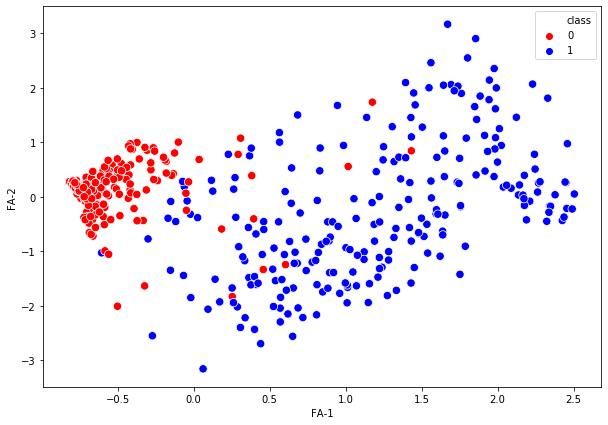

In [5]:
plt.figure(figsize=(10,7))
sns.scatterplot(x=X_fa_7[:, 0],
                y=X_fa_7[:, 1],
                s = 70,
                hue=y, palette=['red','blue'])
plt.xlabel('FA-1')
plt.ylabel('FA-2')
plt.savefig('img/2d FA cluster '+dataset+'.png')
plt.show()

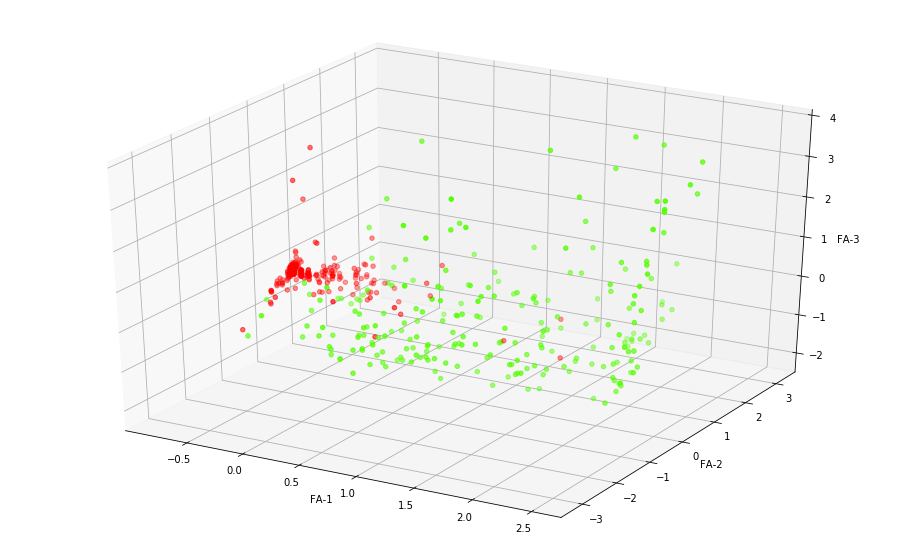

In [6]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=X_fa_7[:, 0], 
    ys=X_fa_7[:, 1], 
    zs=X_fa_7[:, 2], 
    c=y, 
    cmap='prism'
)
ax.set_xlabel('FA-1')
ax.set_ylabel('FA-2')
ax.set_zlabel('FA-3')
plt.savefig('img/3d FA cluster '+dataset+'.png')
plt.show()

In [7]:
N = np.arange(2, 41, 1)
S,H = [],[]
for n in N:
    km = KMeans(n_clusters=n,
                n_init=50, max_iter=1000,
                random_state=44).fit(X_fa_7)
    S.append(silhouette_score(X, km.labels_, metric='euclidean'))
    H.append(homogeneity_score(y, km.labels_))

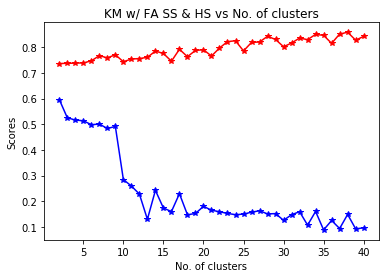

In [8]:
plt.figure()
plt.plot(N, S, '*-',color='b',label='Silhouette')
plt.plot(N, H, '*-',color='r',label='Homogeneity')
plt.title('')
plt.xlabel('No. of clusters')
plt.ylabel('Scores')
plt.title('KM w/ FA SS & HS vs No. of clusters')
plt.savefig('img/FA KM scores '+dataset+'.png')
plt.show()

In [9]:
S, H, L = [],[],[]
for n in N:
    gmm = GaussianMixture(n_components=n,
                          max_iter=100,
                          random_state=44, 
                          n_init=5).fit(X_fa_7)
    l = gmm.predict(X_fa_7)
    S.append(silhouette_score(X, l, metric='euclidean'))
    H.append(homogeneity_score(y, l))
    L.append(gmm.score(X_fa_7))

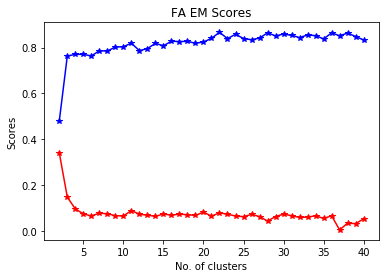

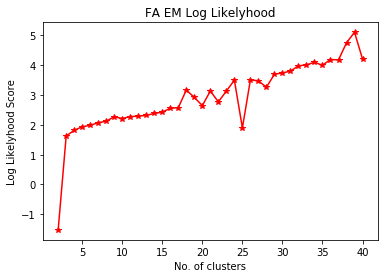

In [10]:
plt.figure()
plt.plot(N, S, '*-',color='r')
plt.plot(N, H, '*-',color='b')
plt.title('FA EM Scores')
plt.xlabel('No. of clusters')
plt.ylabel('Scores')
plt.savefig('img/FA EM scores '+dataset+'.png')
plt.show()

plt.figure()
plt.plot(N, L, '*-',color='r')
plt.title('FA EM Log Likelyhood')
plt.xlabel('No. of clusters')
plt.ylabel('Log Likelyhood Score')
plt.savefig('img/FA EM log '+dataset+'.png')
plt.show()

In [11]:
if dataset_select == 0:
    X_train, X_test, y_train, y_test = train_test_split(X_fa_7, 
                                                        y, 
                                                        test_size=0.3, 
                                                        random_state=42,
                                                        stratify=y)
    nn_clf = MLPClassifier()
    nn_clf.fit(X_train, y_train)
    nn_y_pred = nn_clf.predict(X_test)
    nn_acc = accuracy_score(y_test, nn_y_pred)*100
    print("Tuned Accuracy: %.2f%%"%nn_acc)
    train_sizes, nn_train_scores, test_scores = learning_curve(nn_clf,
                                                               X_train,
                                                               y_train,
                                                               train_sizes=np.linspace(0.1,1.0,10),
                                                               verbose=3,
                                                               n_jobs=2)
    plt.figure()
    plt.plot(train_sizes, np.mean(nn_train_scores, axis=1),'*-',
            label='Training Score',color='blue')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), '*-',
            label='Cross Validation Score',color='red')
    plt.title('NN w/ FA Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Classicication Score')
    plt.legend()
    plt.grid()
    plt.savefig('img/FA_NN_learning '+dataset+'.png')
    plt.show()
    nn_loss= nn_clf.loss_curve_
    plt.figure()
    plt.title('NN w/ FA Loss Curve')
    plt.xlabel('No. of Iterations')
    plt.ylabel('Loss')
    plt.plot(nn_loss, '-', color='red')
    plt.grid()
    plt.savefig('img/FA_NN_loss '+dataset+'.png')
    plt.show()